<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/notebooks/CNN_2_Yolo_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 程式學習目標：
---
* 看懂 yolov2 網路架構
* 學會 keras.models.Model function API networking 
* passthrough for Yolov2
* 參數試試看



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#root = 'drive/My Drive/'
#colabok = root+'ColabOK/'
#coco = colabok + 'YOLO/yolo_prediction/'
path = 'yolo/'
!cp drive/MyDrive/yolo.zip .
!unzip yolo.zip 


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  yolo.zip
replace yolo/yolo_video.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!cp yolo/utils.py ./utils.py
!cp yolo/preprocessing.py ./preprocessing.py

# Initialization

In [ ]:
%tensorflow_version 1.x
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes, normalize

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.7#0.1
NMS_THRESHOLD    = 0.45#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

# Construct the network

In [ ]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

''' 
YAD2K assumes the Keras backend is Tensorflow. In particular for YOLO_v2 models with a passthrough layer, 
YAD2K uses tf.space_to_depth to implement the passthrough layer. 
The evaluation script also directly uses Tensorflow tensors and uses tf.non_max_suppression for the final output.
'''

' \nYAD2K assumes the Keras backend is Tensorflow. In particular for YOLO_v2 models with a passthrough layer, \nYAD2K uses tf.space_to_depth to implement the passthrough layer. \nThe evaluation script also directly uses Tensorflow tensors and uses tf.non_max_suppression for the final output.\n'

In [ ]:


input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4)) # TRUE_BOX_BUFFER = 50

# Layer 1. ###### the 1st Maxpooling
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2. ###### the 2nd Maxpooling
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5. ###### the 3rd Maxpooling
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8. ###### the 4th Maxpooling
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x ###########. this is preparing for what we called passthrough layer, for fine grain, for higher resolution

############## the 5th Maxpooling
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x) ###. (None, 13, 13, 1024)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection) ###### this is from YAD2K
#### above, even skip_connection is from 26,26,512, 
#### but we used (1,1), and squeeze them into 64 channels, 
#### then we have use space to depth x2 to make lower resolution with deeper channels to 64*4 = 256

x = concatenate([skip_connection, x])
# from layer 20, we have (None, 13, 13, 1024)
###### concate 256, so, we have (None, 13,13, 1280)

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x) #BOX = 5 (a grid is with 5 boxes)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
#output = Lambda(lambda args: args[0])([output, true_boxes])
# true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4)) = Input(shape=(1, 1, 1, 50 , 4))

#model = Model([input_image, true_boxes], output)
model = Model(input_image, output)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

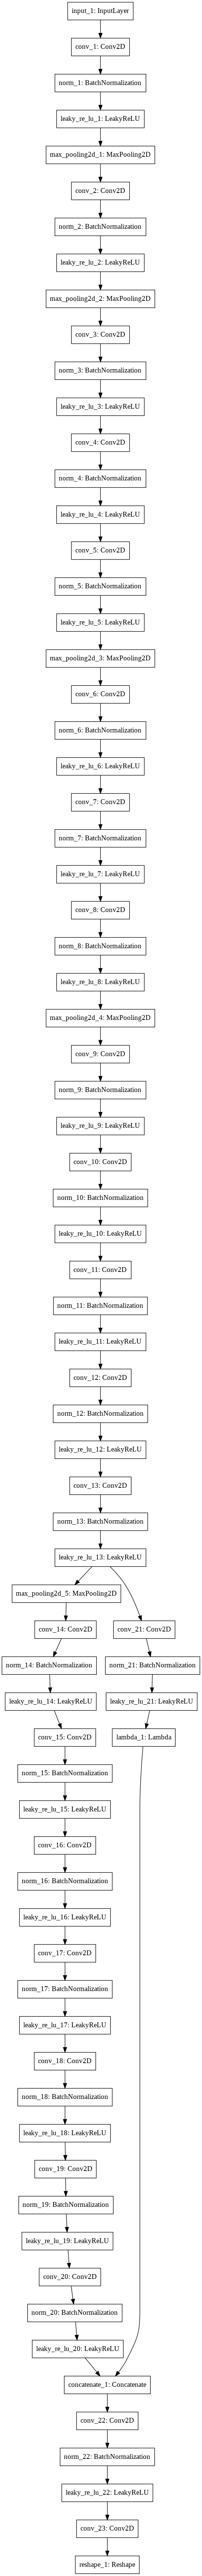

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

# Load Model

In [ ]:

#!wget https://pjreddie.com/media/files/yolo.weights
wt_path =  path+ 'yolo.weights'
weight_reader = WeightReader(wt_path)
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1): # 1 ~ 23 層
    conv_layer = model.get_layer('conv_' + str(i)) # 每一層都先加 conv. 
    
    if i < nb_conv: # 如果不是最後1層，都要加 bn (1~22)
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])   # bn has its parameters...     
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else: #只針對第一層的動作
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

### above settting... why we not considering maxpooling?  it is beca

In [ ]:
# 1. 




---


# 1. 請比對 model.summary 與 load_weight 
# 2. 為什麼 我們的有些 layers 有 maxpooling，有些沒有，但是上面的程式沒有作設定？


---



# Predict Image

In [ ]:
from PIL import Image
from urllib.request import urlopen

im = Image.open(urlopen('https://s2.yimg.com/lo/api/res/1.2/_EO7ZLTvO4MWCPkc8GuOfQ--/YXBwaWQ9eXR3ZnBhZ2U7dz02NDA7cT03NTtzbT0xO2lsPXBsYW5l/http://media.zenfs.com/zh-Hant_TW/News/yahoobeauty/20150611014734_easonhou_249949.jpg'))

In [ ]:
LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.9 #0.1
NMS_THRESHOLD    = 0.1#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

嘗試
1. 
    OBJ_THRESHOLD    = 0.1

    NMS_THRESHOLD    = 0.93
2. 
    OBJ_THRESHOLD    = 0.6

    NMS_THRESHOLD    = 0.45

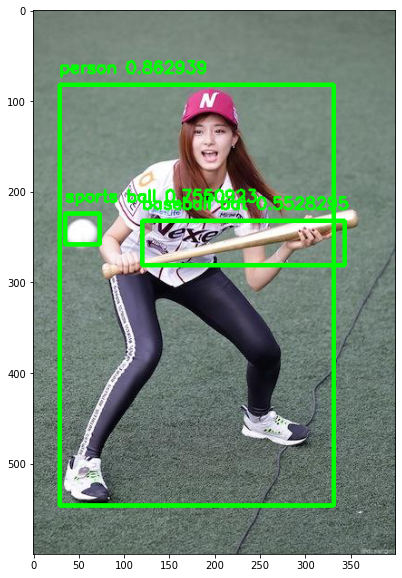

In [ ]:
OBJ_THRESHOLD    = 0.1
NMS_THRESHOLD    = 0.45

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
image = Image.open(urlopen('https://s2.yimg.com/lo/api/res/1.2/_EO7ZLTvO4MWCPkc8GuOfQ--/YXBwaWQ9eXR3ZnBhZ2U7dz02NDA7cT03NTtzbT0xO2lsPXBsYW5l/http://media.zenfs.com/zh-Hant_TW/News/yahoobeauty/20150611014734_easonhou_249949.jpg'))

plt.figure(figsize=(10,10))

input_image = cv2.resize(np.array(image), (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image]) #, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=OBJ_THRESHOLD,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
image = draw_boxes(np.array(image), boxes, labels=LABELS)

plt.imshow(image); plt.show()

In [ ]:
netout.shape

(1, 13, 13, 5, 85)

# Perform detection on video

In [ ]:
#!wget https://storage.googleapis.com/kent-test/ai_school/yolo/test1.mp4

影片來源可以從 youtube 下載
但是通常都沒有下載權，所以會被擋住
為了讓程式跑的順，我把下一格的第四行 remark 掉

In [ ]:
!pip install pytube3
import cv2
from pytube import YouTube
# YouTube('https://www.youtube.com/watch?v=WaZkZ1GWMkU').streams.first().download(filename='taiwan')

影片來源可以自己放到 yolo_pack 底下，然後修改底下
video_inp = colabok + 'Yolo_Pack/檔案名稱'
自訂影片輸出
video_out = colabok + 'Yolo_Pack/檔案名稱'

In [ ]:
#video_inp = './taiwan.mp4' # ./
#video_inp=path+'phnom_penh.mp4'
video_inp=path+'car_chase_01.mp4'

video_out = 'street.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

In [ ]:
video_writer = cv2.VideoWriter(filename=video_out,
                               fourcc=cv2.VideoWriter_fourcc(*'MP4V'), 
                               fps=video_reader.get(cv2.CAP_PROP_FPS), 
                               frameSize=(frame_w, frame_h))

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

for i in tqdm(range(int(nb_frames))):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image]) #, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))

    if not ret : break
    
video_reader.release()
video_writer.release()  

100%|██████████| 350/350 [04:23<00:00,  1.33it/s]
